# Blog Post: Newton's Method for Logistic Regression

In [3]:
%load_ext autoreload
%autoreload 2
from LogisticRegression import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt 
import numpy as np

In [4]:
# generates data for classification problem

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

X, y = classification_data(noise = 0.5)
w = torch.linspace(-1, 1, X.shape[1])

In [5]:
# plots data and boundary decision based on w
# only works for dimension = 2

def plot_data_and_boundary(X, y, w, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the data
    targets = [0, 1]
    markers = ["o", ","]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = colors[i], cmap = "BrBG", marker = markers[i])

    # Draw the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='black')

    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    plt.show()

In [6]:
# calculates the accuracy of a model

def accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum()
    total = y_true.shape[0]
    print(correct)
    return correct / total

In [24]:
LR = LogisticRegression(w)
opt = NewtonOptimizer(LR, w)

losses = []

for _ in range(1000):
    losses.append(LR.loss(X, y))
    opt.step(X, y, alpha = 200)

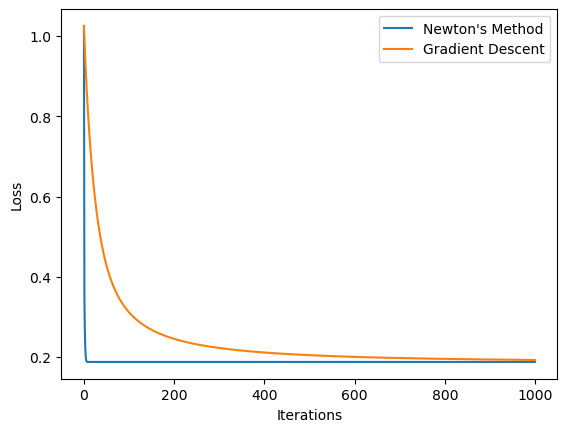

In [25]:
w = torch.linspace(-1, 1, X.shape[1])
w_prev = torch.linspace(-1, 1, X.shape[1])

LR_grad = LogisticRegression(w)
opt = GradientDescentOptimizer(LR_grad, w, w_prev)

losses_grad = []

for _ in range(1000):
    losses_grad.append(LR_grad.loss(X, y))
    opt.step(X, y, alpha = 0.2, beta = 0)

plt.plot(losses, label="Newton's Method")
plt.plot(losses_grad, label = "Gradient Descent")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

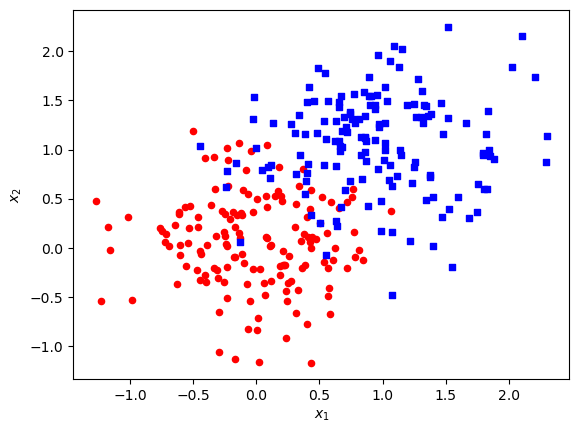

In [23]:
plot_data_and_boundary(X, y, w)